# ELEC474 Prelab5

In [53]:
import cv2 as cv
import numpy as np
import random
import math
import time
from matplotlib import pyplot as plt

In [54]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

img1Name = "computers_left.png"
img2Name = "computers_right.png"
img3Name = "daft_punk_left.jpg"
img4Name = "daft_punk_right.jpg"
# img3Name = "test1.jpg"
# img4Name = "test2.jpg"

img1 = cv.imread(img1Name)
img2 = cv.imread(img2Name)
img3 = cv.imread(img3Name)
img4 = cv.imread(img4Name)


imgDescipt_1 = np.array((
"Left Key Point",
"Right Key Points"
))

imgDescipt_2 = np.array((
"Select point Output",
"Epipolar Line Output"
))

WINDOW_NAME1 = "1.2 Output Image_1"
WINDOW_NAME2 = "1.2 Output Image_2"
WINDOW_NAME3 = "1.3 Input left"
WINDOW_NAME4 = "1.3 Input Right"
WINDOW_NAME5 = "1.3 output 1"
WINDOW_NAME6 = "1.3 output 2"

# 1.1

In [55]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

In [56]:
def SIFTOut(img, flag): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = my_SIFT_instance.detectAndCompute(imgGray,None)
    imgKpOut = cv.drawKeypoints(imgKpOut,kp,0)
    return (imgKpOut,kp,des)

def FlannBasedMatchLoweRatio(img1Param,img2Param,
                            index_param,search_param,
                            kNum, ratio):
    img1Kp = img1Param[1]
    img2Kp = img2Param[1]
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(img1Param[2],img2Param[2],k = kNum)

    loweMatch = []
    loweImg1Point = []
    loweImg2Point = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])
            loweImg1Point.append(img1Kp[m.queryIdx].pt) #NOTE: append requried left and right points  
            loweImg2Point.append(img2Kp[m.trainIdx].pt)

    imgOut = cv.drawMatchesKnn(img1Param[0],img1Kp,img2Param[0],img2Kp,loweMatch,None,flags=2)
    return imgOut, loweMatch, loweImg1Point, loweImg2Point

In [57]:
def Matching(img1, img2, flag):
    outImages = []
    keyPoints = []
    descriptors = []
    img1Param = SIFTOut(img1, flag)
    img2Param = SIFTOut(img2, flag)

    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    flannOutImg, Matches, leftPoint, rightPoint = FlannBasedMatchLoweRatio(img1Param, img2Param,
                            index_params, search_params,
                            kNum = 2, ratio = 0.8)  #NOTE: The ratio difference of lowe will result in different epiploar lines 

    #classify params 
    outImages.append(img1Param[0])
    outImages.append(img2Param[0])
    # outImages.append(flannOutImg)

    keyPoints.append(img1Param[1])
    keyPoints.append(img2Param[1])

    descriptors.append(img1Param[2])
    descriptors.append(img2Param[2])
    #Plt to check
    # PltImg(outImages, imgDescipt_1)

    return keyPoints,descriptors,Matches, leftPoint, rightPoint

In [58]:

Matching(img1, img2, 1)
print("Finish")

Finish


# 1.2

In [59]:
def CVInit(winName):
    cv.namedWindow(winName, cv.WINDOW_NORMAL)

In [60]:
def EpipolarDrawLine(img1, lines, leftPoint, rightPoint, flag): #flag == 1 is dealing set of points , flag == 0 is dealing with one point
    col = img1.shape[1]
    outImg = np.copy(img1)
    rdColor = (0,255,0)
    for line, lpt in zip(lines, leftPoint):
        line = line[0]
        x1,y1 = [0, int(-line[2]/line[1])]  #NOTE: calculate bound points 
        x2,y2 = [col, int(-(line[2]+line[0]*col)/line[1])]
        if flag == 1:
            rdColor = tuple(np.random.randint(0,255,size = 3).tolist())
            outImg = cv.circle(outImg, tuple(lpt[0]), 5, rdColor, -1)
        outImg = cv.line(outImg, (x1,y1), (x2,y2), rdColor, thickness = 1)
    return outImg
    

In [61]:
def EpipolarLineCal(img1, img2):
    point1 = []
    point2 = []
    pltImage1 = []
    _,_,_,point1,point2 = Matching(img1, img2, flag = 1)
    point1 = np.int32(point1)
    point2 = np.int32(point2)
    F, mask = cv.findFundamentalMat(point1, point2, cv.FM_LMEDS)
    
    # point1 = point1[mask.ravel()==1] #this method works as well, turn matrix into 1 dimension 
    point1 = point1[mask.reshape(-1)==1].reshape(-1,1,2)    #NOTE: use mask to filter left and right points 
    point2 = point2[mask.reshape(-1)==1].reshape(-1,1,2)
    
    line1 = cv.computeCorrespondEpilines(point2, 2, F)
    line2 = cv.computeCorrespondEpilines(point1, 1, F)
    outImg1 = EpipolarDrawLine(img1, line1, point1, point2, flag = 1)
    outImg2 = EpipolarDrawLine(img2, line2, point2, point1, flag = 1)
    
    pltImage1.append(outImg1)
    pltImage1.append(outImg2)
    PltImg(pltImage1,["Left", "right"])
    return [outImg1, outImg2]


<Figure size 1800x1200 with 0 Axes>

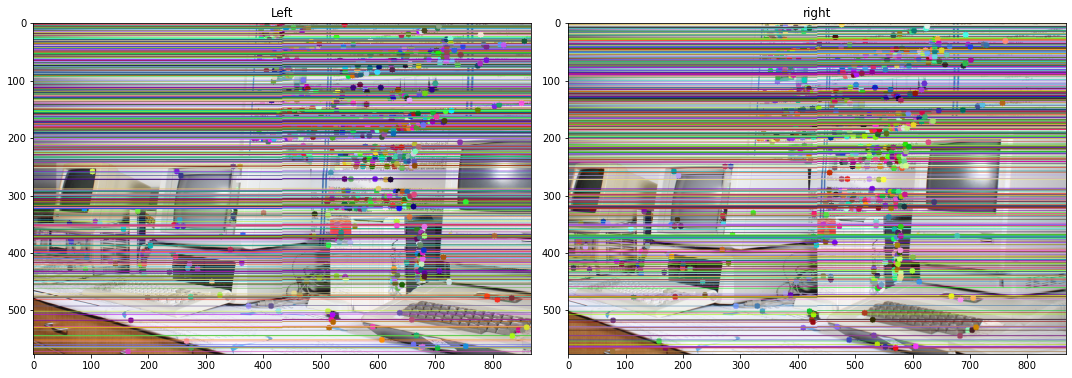

<Figure size 1800x1200 with 0 Axes>

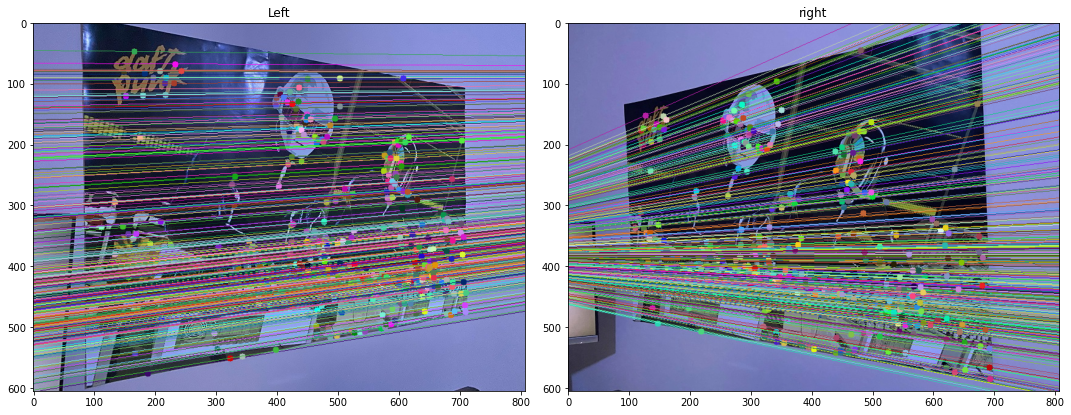

In [62]:

imgSize = img1.shape
outImg1 = EpipolarLineCal(img1, img2)
outImg2 = EpipolarLineCal(img3, img4)

# CVInit(WINDOW_NAME1)
# CVInit(WINDOW_NAME2)

# while True:
#     #cv imshow    
#     cv.imshow(WINDOW_NAME1, outImg1[0])
#     cv.imshow(WINDOW_NAME1, outImg1[1])
#     cv.imshow(WINDOW_NAME2, outImg2[0])
#     cv.imshow(WINDOW_NAME2, outImg2[1])
    
#     k = cv.waitKey(1)
#     if k == 27:
#         break                                               #press ESC to exit the program  
# cv.destroyAllWindows()



# 1.3

In [63]:
def EpipolarLineCalPointRefelect(event,  x,  y,  flags,  param):
    if event == cv.EVENT_LBUTTONUP:

        cv.destroyAllWindows()
        _img1 = np.copy(param[0])
        _img2 = np.copy(param[1])
        pointIdx = [x,y]
        # print("this",pointIdx)
        _,_,_,point1,point2 = Matching(_img1, _img2, flag = 1)
        point1 = np.int32(point1)
        point2 = np.int32(point2)
        F, _ = cv.findFundamentalMat(point1, point2, cv.FM_LMEDS)
        # print("check",point1)
        point1[-1] = pointIdx #Note: since computeCorrespondEpilines required more than one point, then just replace the last point in here(not the best solution)
        # print("second",point1)
        line = [cv.computeCorrespondEpilines(point1, 1, F)[-1]]
        # print("line",line)
        
        outImg1 = cv.circle(_img1, tuple(pointIdx), 5, (0,255,0), -1)
        outImg2 = EpipolarDrawLine(_img2, line, point2, point1, flag = 0)
        
        cv.imshow(WINDOW_NAME5, outImg1)
        cv.imshow(WINDOW_NAME6, outImg2)
        
        PltImg([outImg1,outImg2],imgDescipt_2)
        
        

In [64]:
def EpipolarLineSeclection(img1, img2):
    while True:
        cv.imshow(WINDOW_NAME3, img1)
        cv.imshow(WINDOW_NAME4, img2)
        cv.setMouseCallback(WINDOW_NAME3,EpipolarLineCalPointRefelect,[img1, img2])
        cv.setMouseCallback(WINDOW_NAME4,EpipolarLineCalPointRefelect,[img2, img1])
        k = cv.waitKey(1)
        if k == 27:
            break                                               #press ESC to exit the program  
    cv.destroyAllWindows()

<Figure size 1800x1200 with 0 Axes>

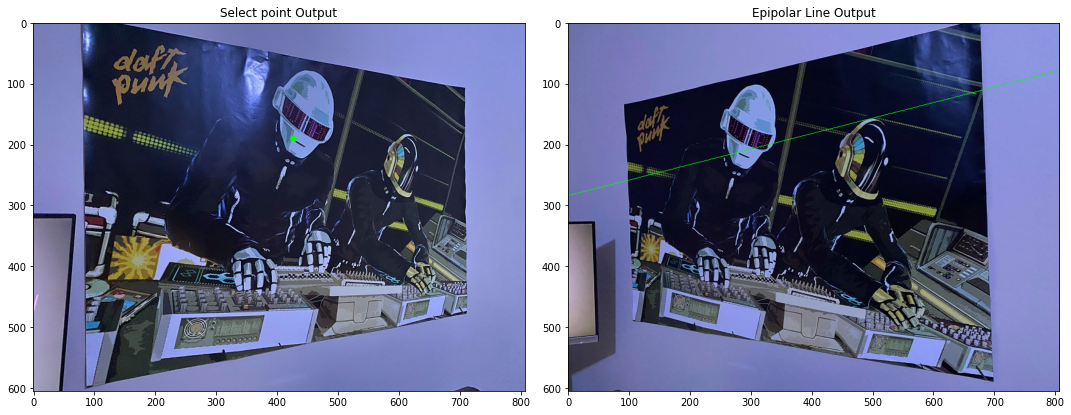

<Figure size 1800x1200 with 0 Axes>

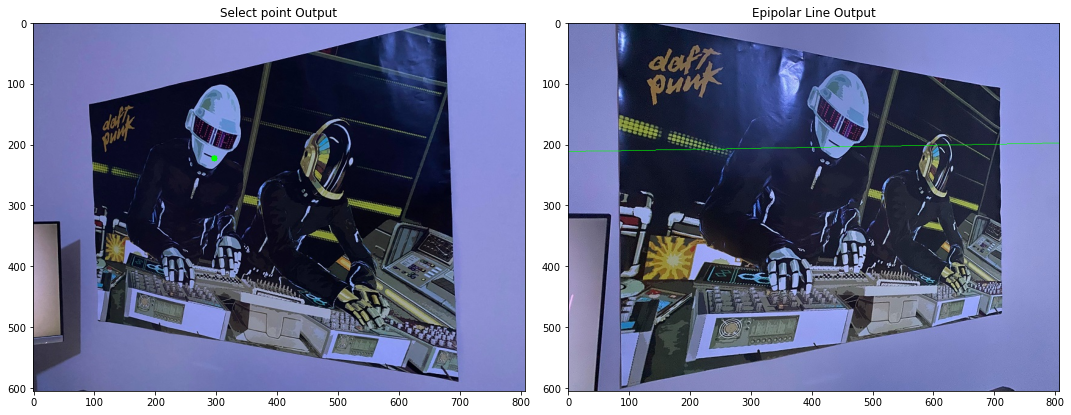

<Figure size 1800x1200 with 0 Axes>

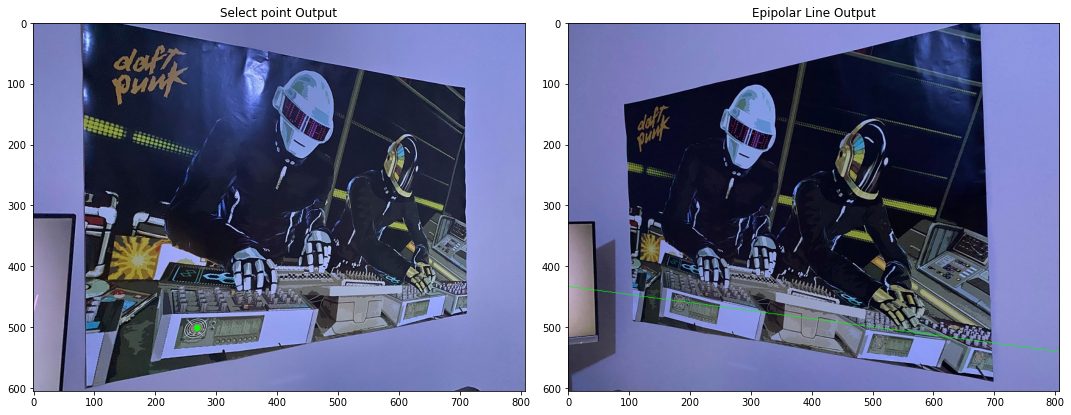

<Figure size 1800x1200 with 0 Axes>

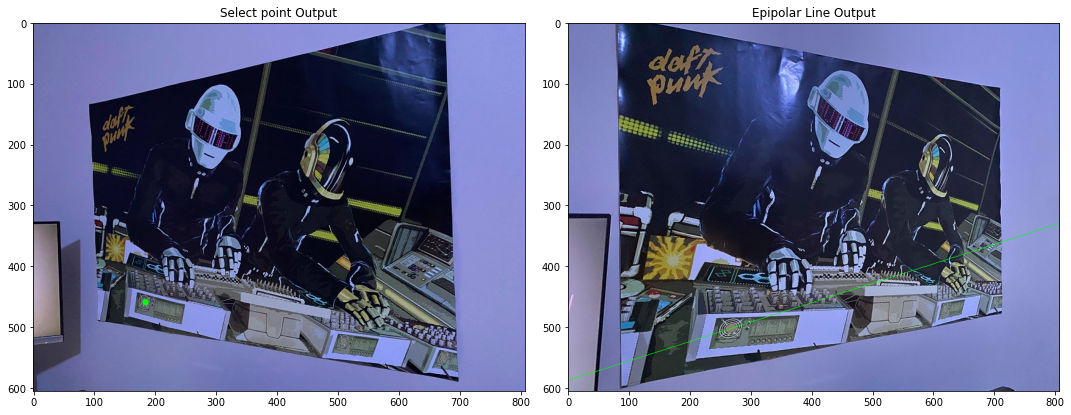

In [65]:
EpipolarLineSeclection(img3, img4)